For 'no_scaling', available test subsets: ['unseen_subject', 'unseen_task', 'unseen_both']
For 'robust', available test subsets: ['unseen_subject', 'unseen_task', 'unseen_both']
For 'standard', available test subsets: ['unseen_subject', 'unseen_task', 'unseen_both']
For 'both', available test subsets: ['unseen_subject', 'unseen_task', 'unseen_both']


/tmp/ipykernel_3134409/3195381148.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(metrics_path)


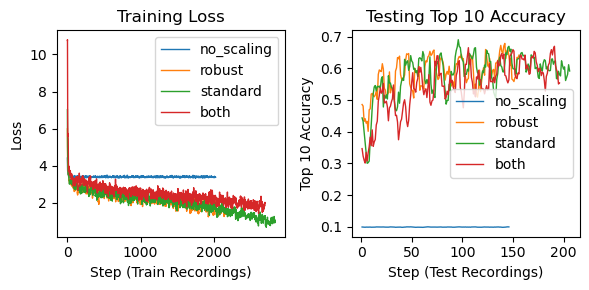

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import typing as tp
import numpy as np


def moving_average(values: tp.List[float], window_size: int) -> tp.List[float]:
    """Compute a simple moving average of a list of values."""
    if window_size <= 1:
        return values  # No smoothing
    cumsum = np.cumsum(np.insert(values, 0, 0))
    smoothed = (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)
    return smoothed.tolist()


def display_metrics(
    studies: tp.Dict[str, str],
    train_metric: str = "loss",
    test_metric: str = "top_10_accuracy",
    test_subset: str = None,
    smooth_window: int = 1,  # Increase to >1 to apply smoothing
):
    """
    Displays specified training and test metrics for multiple experiments side by side.
    Applies optional smoothing to reduce noise.

    Arguments:
        studies: A dictionary where keys are titles (labels) for the experiments and
                 values are paths to the corresponding saved training sessions.
        train_metric: The name of the metric to plot for training data.
        test_metric: The name of the metric to plot for test data.
        test_subset: If provided, select a particular test subset from metrics["test"].
                     If None, the first available test subset is chosen.
        smooth_window: Window size for moving average smoothing. 1 means no smoothing.
    """

    # Configure fonts and style for a compact, paper-friendly figure
    plt.rc("font", size=8)
    plt.rc("axes", titlesize=8)
    plt.rc("axes", labelsize=8)
    plt.rc("xtick", labelsize=6)
    plt.rc("ytick", labelsize=6)
    plt.rc("legend", fontsize=6)

    # Try to use seaborn-whitegrid style; if not available, revert to default
    try:
        plt.style.use("seaborn-whitegrid")
    except OSError:
        print(
            "Warning: 'seaborn-whitegrid' style is not available. Using default style."
        )
        plt.style.use("default")

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    ax_train, ax_test = axes

    for title, save_path in studies.items():
        metrics_path = os.path.join(save_path, "metrics.pt")
        if not os.path.exists(metrics_path):
            print(
                f"Warning: No metrics found at {metrics_path} for '{title}'. Skipping."
            )
            continue

        data = torch.load(metrics_path)
        metrics = data.get("metrics", {})

        # Extract training metrics
        train_data = metrics.get("train", [])
        if len(train_data) == 0:
            print(
                f"No training metrics found for '{title}'. Available sets: {list(metrics.keys())}. Skipping."
            )
            continue

        # Check if the requested train_metric is present
        available_train_metrics = train_data[0].keys() if len(train_data) > 0 else []
        if train_metric not in available_train_metrics:
            print(
                f"Training metric '{train_metric}' not found for '{title}'. "
                f"Available training metrics: {list(available_train_metrics)}"
            )
            continue

        train_values = [m[train_metric] for m in train_data if train_metric in m]
        if smooth_window > 1:
            train_values = moving_average(train_values, smooth_window)
            train_x = range(1, len(train_values) + 1)
        else:
            train_x = range(1, len(train_values) + 1)

        ax_train.plot(train_x, train_values, label=title, linewidth=1)

        # Extract testing metrics
        test_dict = metrics.get("test", {})
        if len(test_dict) == 0:
            print(
                f"No test metrics found for '{title}'. Available sets: {list(metrics.keys())}. Skipping test plot."
            )
            continue

        # Print out available test subsets for clarity
        available_test_subsets = list(test_dict.keys())
        print(f"For '{title}', available test subsets: {available_test_subsets}")

        if test_subset is None:
            # If no subset specified, just pick the first available test subset
            selected_test = available_test_subsets[0]
            print(f"No test_subset specified for '{title}'. Using '{selected_test}'.")
        else:
            selected_test = test_subset
            if selected_test not in test_dict:
                print(
                    f"Test subset '{selected_test}' not found for '{title}'. "
                    f"Available test subsets: {available_test_subsets}"
                )
                continue

        test_data_list = test_dict[selected_test]
        if len(test_data_list) == 0:
            print(
                f"No test data for subset '{selected_test}' in '{title}'. Available subsets: {available_test_subsets}"
            )
            continue

        # Check if requested test_metric is present
        available_test_metrics = (
            test_data_list[0].keys() if len(test_data_list) > 0 else []
        )
        if test_metric not in available_test_metrics:
            print(
                f"Test metric '{test_metric}' not found for '{title}' in subset '{selected_test}'. "
                f"Available test metrics: {list(available_test_metrics)}"
            )
            continue

        test_values = [m[test_metric] for m in test_data_list if test_metric in m]
        if smooth_window > 1:
            test_values = moving_average(test_values, smooth_window)
            test_x = range(1, len(test_values) + 1)
        else:
            test_x = range(1, len(test_values) + 1)

        ax_test.plot(test_x, test_values, label=title, linewidth=1)

    # Set labels and titles
    ax_train.set_ylabel(train_metric.replace("_", " ").title())
    ax_train.set_xlabel("Step (Train Recordings)")
    ax_train.set_title("Training " + train_metric.replace("_", " ").title())

    ax_test.set_ylabel(test_metric.replace("_", " ").title())
    ax_test.set_xlabel("Step (Test Recordings)")
    ax_test.set_title("Testing " + test_metric.replace("_", " ").title())

    # Add legends where data is present
    if len(ax_train.lines) > 0:
        ax_train.legend(loc="best")
    if len(ax_test.lines) > 0:
        ax_test.legend(loc="best")

    plt.tight_layout()
    plt.show()


# Example usage:
studies = {
    "no_scaling": "saves/phase1/ablation/scaling/Dec19_no_scaling/epoch_15",
    "robust": "saves/phase1/ablation/scaling/Dec19_robust_only/epoch_16",
    "standard": "saves/phase1/ablation/scaling/Dec19_standard_only/epoch_21",
    "both": "saves/phase1/objective/Dec18_CLIP_MSE_384/epoch_20",
}

# Using a moving average window of 5 to smooth the curves
display_metrics(
    studies,
    train_metric="loss",
    test_metric="top_10_accuracy",
    smooth_window=5,
    test_subset="unseen_subject",
)